<a href="https://colab.research.google.com/github/Ronit-Ramnarayan/Generative_adversarial_network/blob/main/generative_adversarial_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, I will be implementing a Generative Adversarial Network (GAN) using the MNIST dataset. A GAN is a generative model that takes a small input like a few numbers, for example, and produces a complex output, like an image of digits (which is what this project will be doing).



## Model Overview

A generative model (𝐺) is pitted against an adversary: a
discriminative (𝐷) model that learns to determine whether a sample is from the generative model distribution or the data distribution.



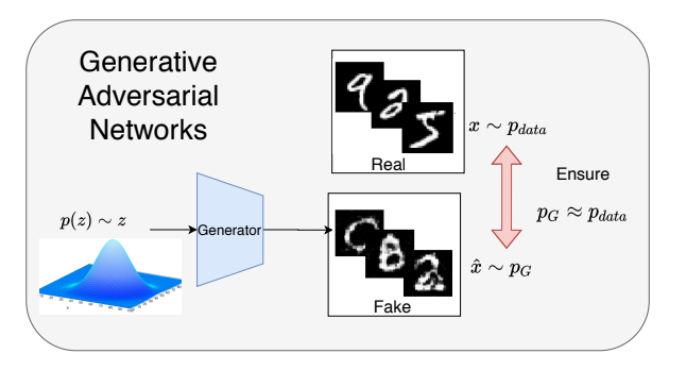

*   Introduce latent variable z with simple prior $p(𝑧)$ (e.g. Gaussian)
*   Sample $z ∼ p(𝑧)$, pass it through Generator $\hat{x} = G(z)$; where $\hat{x} ∼ p_G$
*   Introduce mechanism to ensure $p_G ≈ p_{data}$


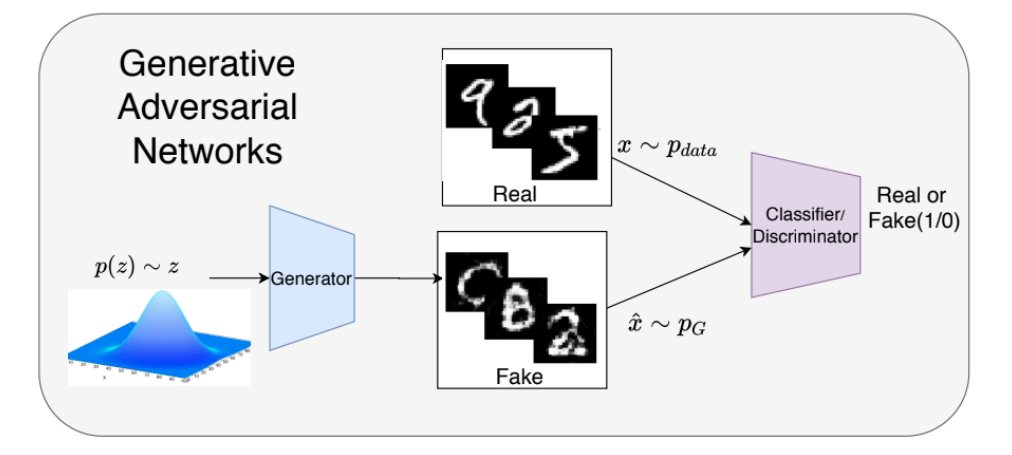

* Use a classifier (called discriminator) that differentiates between real samples $x ∼ p_{data} (class 1)$ and $\hat{x} ∼ p_{G} (class 0)$
* Train generator G such that discriminator misclassifies generated sample \hat{x} into class 1
=⇒ can no more differentiate between $x ∼ p_{data}$ and $\hat{x} ∼ p_{G}$

In [2]:
# Import Libraries
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set for testing purposes
seed = 0
torch.manual_seed(seed) #
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


The below function is for visualizing images: Given a tensor of images, number of images, and size per image, plots and prints the images in a uniform grid.

In [3]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Generator Architecture

This function creates a single block for generator network given input_dim and output_dim

This block contains
1. Linear transformation to map to another shape,
  * in_features=input_dim
  * out_features=output_dim
2. Batch Normalization
  * num_features : output_dim
3. Activation Function (Relu)
  * inplace : True
  
  
Returns a generator neural network layer, with a linear transformation followed by a batch normalization and then a relu activation. We will be using this blocks to create a generator

In [5]:
def get_generator_block(input_dim, output_dim):

    return nn.Sequential(
        nn.Linear(in_features=input_dim, out_features=output_dim),
        nn.BatchNorm1d(num_features=output_dim),
        nn.ReLU(inplace=True)
    )

Below we implement a Generator Class

* Architecture of the Generator looks like this :

  z_dim : the dimension of the noise vector =10
  
  im_dim: dimension of the flattened images=784,
  
  hidden_dim=128
  * Generator block( 10 , 128)
  * Generator block( 128 , 128*2)
  * Generator block( 128 * 2 , 128 * 4)
  * Generator block( 128 * 4 , 128 * 8)
  * Linear layer
  * Sigmoid Activation

A function for completing a forward pass of the generator. Given a noise tensor, returns generated images.





In [7]:
class Generator(nn.Module):

    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(

            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            # Final Layer containing Linear transformation with in_features from previous layer and out_features as im_dim
            nn.Linear(in_features=(hidden_dim * 8), out_features=im_dim),
            # Sigmoid Activation Function
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.gen(noise)

    def get_gen(self):
        return self.gen

## Noise

To train generator, we need to create noise vectors.

This function generates noise vector by sampling random numbers from the normal distribution given
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type

In [8]:

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples,z_dim,device=device)

## Discriminator Architecture

This function creates a single block for Discriminator network given input parameters

input_dim: the dimension of the input vector, a scalar

output_dim: the dimension of the output vector, a scalar

This block contains
1. Linear transformation to map to another shape,
  * in_features=input_dim, out_features=output_dim
2. Activation Function (Relu)
  * negative_slope = 0.2 , inplace =True

It returns a neural network block of the discriminator. We are going to stack many number of blocks to create Discriminator Architecture.

In [9]:
def get_discriminator_block(input_dim, output_dim):

    return nn.Sequential(
        nn.Linear(in_features=input_dim, out_features=output_dim),
        nn.LeakyReLU(negative_slope=0.2,inplace=True)
    )

In the Discriminator class we will build a network with 4 layers. Start with the image tensor and perform the transformation until it returns a single number (i.e. 1-dimensional tensor output)

Each intermediate layer in the network will have hidden_dim

Architecture of the Discriminator is as given below :

im_dim: the dimension of the flattened images, fitted for the dataset used, a scalar (MNIST images are 28x28 = 784 so that is your default)

hidden_dim: the inner dimension, a scalar

* Discriminator block( 784 , 128 * 4)
* Discriminator block( 128 * 4 , 128 * 2)
* Discriminator block( 128 * 2 , 128)
* Linear layer

This has only linear transformation with in_features: hidden_dim and out_features: 1

In [10]:
class Discriminator(nn.Module):

    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # Layer - 1
            get_discriminator_block(im_dim, hidden_dim * 4),
            # Layer-2
            get_discriminator_block(hidden_dim * 4,hidden_dim*2),
            # Layer-3
            get_discriminator_block(hidden_dim*2, hidden_dim),
            #Discriminator Architecture
            nn.Linear(in_features=hidden_dim, out_features=1)
        )

    def forward(self, image):
        return self.disc(image)

    def get_disc(self):
        return self.disc

## Loading data

In [13]:

batch_size = 128

# Check availability of GPU and set the device accordingly
device = 'cuda'

# The following block is to mitigate the temporary issue within PyTorch about downloading MNIST.
"""new_mirror = 'https://ossci-datasets.s3.amazonaws.com/mnist'
MNIST.resources = [
   ('/'.join([new_mirror, url.split('/')[-1]]), md5)
   for url, md5 in MNIST.resources
]"""
# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

In [14]:
z_dim = 64
# create a generator
gen = Generator(z_dim).to(device)

# create a discriminator
disc = Discriminator().to(device)


$$
\text { Training Objective: } \min _{G} \max _{D}\left(\mathbb{E}_{x \sim p_{\text {data }}}[\log D(x)]+\mathbb{E}_{z \sim p_{z}}[\log (1-D(G(z))])\right.
$$

$$
O_{1}=\max _{D} \mathbb{E}_{x \sim p_{\text {data }}}[\log D(x)]
$$
Train discriminator, $D$, such that if sample belongs to $p_{\text {data }}$, maximize the log probability of it being a real sample

$$
O_{2}=\min _{G} \mathbb{E}_{z \sim p_{z}}[\log (1-D(G(z))]
$$
Train Generator, $G$ such that if sample belongs to $p_{G}($ i.e $G(z))$, maximize the log probability of it being a real sample

* for number of training iterations do

  * for $k$ steps do
    - Sample minibatch of $m$ noise samples from noise prior $p_{g}(\boldsymbol{z})$.
    - Sample minibatch of $m$ examples from data generating distribution $p_{\text {data }}(\boldsymbol{x}) .$
    - Update the discriminator by ascending its stochastic gradient:
$$
\nabla_{\theta_{d}} \frac{1}{m} \sum_{i=1}^{m}\left[\log D\left(\boldsymbol{x}^{(i)}\right)+\log \left(1-D\left(G\left(\boldsymbol{z}^{(i)}\right)\right)\right)\right]
$$
  * end for
  - Sample minibatch of $m$ noise samples $\left\{\boldsymbol{z}^{(1)}, \ldots, \boldsymbol{z}^{(m)}\right\}$ from noise prior $p_{g}(\boldsymbol{z})$.
  - Update the generator by descending its stochastic gradient:
$$
\nabla_{\theta_{g}} \frac{1}{m} \sum_{i=1}^{m} \log \left(1-D\left(G\left(\boldsymbol{z}^{(i)}\right)\right)\right)
$$
* end for

The gradient-based updates can use any standard gradient-based learning rule. We used momentum in our experiments.

## Discriminator loss function
This function returns the loss of the discriminator given inputs.

  * gen: the generator model, which returns an image given z-dimensional noise

  * disc: the discriminator model, which returns a single-dimensional prediction of real/fake

  * criterion: the loss function, which should be used to compare the discriminator's predictions to the ground truth reality of the images (e.g. fake = 0, real = 1)

  * real: a batch of real images
  * num_images: the number of images the generator should produce, which is also the length of the real images

  * z_dim: the dimension of the noise vector, a scalar
  * device: the device type


Create noise vectors, use existing defined get_noise function to create noise. Pass this noise vectors as input to generate batch (num_images) of fake images using gen defined above.

These generated fake images are passed to discriminator for prediction  using disc defined above. Make sure to use .detach() on generator results i.e. fake.detach() since generator is needed to calculate discriminator loss.
This ensures that only the discriminator is updated

Calculate loss using criterion defined earlier.Ground truth for fake images are all zeros

Pass the batch of real images to discriminator for predictions using disc defined above

Calculate loss using criterion defined earlier. Ground truth for real images are all ones

Take avg of disc_fake_loss and disc_real_loss and return the average discriminator loss

In [15]:
def gen_fake(gen, num_images, z_dim, device):
  #Fake Image Generation
  fake_noise = get_noise(num_images, z_dim, device="cuda")
  fake = gen(fake_noise)
  return fake

In [16]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):

    fake = gen_fake(gen, num_images, z_dim, device)

    #Discriminator Loss Function

    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2

    return disc_loss


## Generator Loss function

This function gives loss of the Generator given inputs
* gen: the generator model, which returns an image given z-dimensional noise
* disc: the discriminator model, which returns a single-dimensional prediction of real/fake
* criterion: the loss function, which should be used to compare the discriminator's predictions to the ground truth reality of the images (e.g. fake = 0, real = 1)
* num_images: the number of images the generator should produce, which is also the length of the real images
* z_dim: the dimension of the noise vector, a scalar
* device: the device type



Create noise vectors, use existing defined get_noise function to create noise, ensure use of device argument.

Pass this nosie vectors to generate a batch (num_images) of fake images by using gen defined above.

Also collect Discriminator predictions on the above generated fake images using disc defined earlier

Calculate generator loss using criterion.For Ground truth remember that generator wants discriminator to think that fake images are real

In [18]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):

    fake = gen_fake(gen, num_images, z_dim, device)

    #Generator Loss Function

    disc_fake_pred = disc(fake)

    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

    return gen_loss

## Training

In [ ]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
display_step = 500
lr = 0.00001

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)


cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):

    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        real = real.view(cur_batch_size, -1).to(device)

        disc_opt.zero_grad()

        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        disc_loss.backward(retain_graph=True)

        disc_opt.step()

        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        # Zero out the gradients
        gen_opt.zero_grad()
        # Calculate generator loss, use existing function get_gen_loss defined for loss calculation
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        # Backprop through the generator: update the gradients
        gen_loss.backward(retain_graph=True)
        # update optimizer
        gen_opt.step()

        if test_generator: # For testing purposes, to check that code changes the generator weights
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        mean_discriminator_loss += disc_loss.item() / display_step

        mean_generator_loss += gen_loss.item() / display_step

        if cur_step % display_step == 0 and cur_step > 0: ### Visualization code ###
            print(f"Epoch {epoch} Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            image_unflat = fake.detach().cpu().view(-1, *(1, 28, 28))
            image_grid = make_grid(image_unflat[:25], nrow=5)
            save_image(image_grid, "training_image.png")
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1 Step 500: Generator loss: 1.3885548167228687, discriminator loss: 0.41952419614791914


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2 Step 1000: Generator loss: 1.6737333312034612, discriminator loss: 0.29895052823424334


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3 Step 1500: Generator loss: 1.9684414880275722, discriminator loss: 0.1732783018946646


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4 Step 2000: Generator loss: 1.8015379319190972, discriminator loss: 0.190735673993826


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5 Step 2500: Generator loss: 1.7579443323612203, discriminator loss: 0.1925305354595186


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6 Step 3000: Generator loss: 2.029374316930772, discriminator loss: 0.15304788941144948


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7 Step 3500: Generator loss: 2.458286284446716, discriminator loss: 0.12642153504490852


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8 Step 4000: Generator loss: 2.608780699729916, discriminator loss: 0.12222420765459555


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9 Step 4500: Generator loss: 3.193453397274014, discriminator loss: 0.09383957411348816


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10 Step 5000: Generator loss: 3.4294180564880383, discriminator loss: 0.07619683792442086


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11 Step 5500: Generator loss: 3.5443762764930744, discriminator loss: 0.08194084253162146


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12 Step 6000: Generator loss: 3.5917965950965876, discriminator loss: 0.08072325345873826


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13 Step 6500: Generator loss: 3.895389514446261, discriminator loss: 0.05907046514004473


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14 Step 7000: Generator loss: 3.9655698227882383, discriminator loss: 0.06137345345318314


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15 Step 7500: Generator loss: 3.999828872680664, discriminator loss: 0.0628109421208501


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17 Step 8000: Generator loss: 4.073727273941036, discriminator loss: 0.061813718795776344


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18 Step 8500: Generator loss: 3.9632558865547205, discriminator loss: 0.068531757183373


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19 Step 9000: Generator loss: 4.106924991130827, discriminator loss: 0.07593427758663891


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20 Step 9500: Generator loss: 3.933017879486083, discriminator loss: 0.06907951721549033


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21 Step 10000: Generator loss: 3.8693380627632137, discriminator loss: 0.07462172292917973


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22 Step 10500: Generator loss: 3.8168259620666527, discriminator loss: 0.06928982046246522


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23 Step 11000: Generator loss: 4.162392958641054, discriminator loss: 0.05891423951461914


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24 Step 11500: Generator loss: 4.323081994056697, discriminator loss: 0.059588862292468577


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25 Step 12000: Generator loss: 4.237172344684602, discriminator loss: 0.07477597283571963


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26 Step 12500: Generator loss: 3.9739963383674644, discriminator loss: 0.07642994711548087


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27 Step 13000: Generator loss: 4.083824549674983, discriminator loss: 0.07528406909480694


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28 Step 13500: Generator loss: 3.95916322994232, discriminator loss: 0.08546714451909063


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29 Step 14000: Generator loss: 3.8464058628082305, discriminator loss: 0.09785242957621815


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30 Step 14500: Generator loss: 3.7936335425376893, discriminator loss: 0.10029436711221935


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31 Step 15000: Generator loss: 3.8248362536430363, discriminator loss: 0.09188122370094053


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33 Step 15500: Generator loss: 3.7320756940841666, discriminator loss: 0.10731010200083249


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 34 Step 16000: Generator loss: 3.4693011984825133, discriminator loss: 0.12289791057258853


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 35 Step 16500: Generator loss: 3.4948436231613176, discriminator loss: 0.12241815708577627


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 36 Step 17000: Generator loss: 3.494633018016816, discriminator loss: 0.12322849749028678


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 37 Step 17500: Generator loss: 3.5807994942665107, discriminator loss: 0.11501512051373709


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 38 Step 18000: Generator loss: 3.5098831911087034, discriminator loss: 0.12407251892238848


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 39 Step 18500: Generator loss: 3.470354751586914, discriminator loss: 0.1427829220890999


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40 Step 19000: Generator loss: 3.269781189441682, discriminator loss: 0.1424627026244998


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 41 Step 19500: Generator loss: 3.2758245434761037, discriminator loss: 0.1412153605371712


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 42 Step 20000: Generator loss: 3.2158100814819326, discriminator loss: 0.15420162101089951


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 43 Step 20500: Generator loss: 3.2278150849342353, discriminator loss: 0.1601291487514972


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 44 Step 21000: Generator loss: 3.1972262516021757, discriminator loss: 0.1552784882634881


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 45 Step 21500: Generator loss: 3.261540553092958, discriminator loss: 0.15233424161374554


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 46 Step 22000: Generator loss: 3.0753969483375556, discriminator loss: 0.17195247647166265


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 47 Step 22500: Generator loss: 3.063611828804018, discriminator loss: 0.17485565185546875


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 49 Step 23000: Generator loss: 2.999425740242005, discriminator loss: 0.17191221253573905


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 50 Step 23500: Generator loss: 3.0073386335372914, discriminator loss: 0.17735782204568382


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 51 Step 24000: Generator loss: 2.8926166152954083, discriminator loss: 0.19924593104422103


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 52 Step 24500: Generator loss: 3.0676421766281154, discriminator loss: 0.17893826983869085


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 53 Step 25000: Generator loss: 3.078864626407624, discriminator loss: 0.18564273306727394


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 54 Step 25500: Generator loss: 2.91566395330429, discriminator loss: 0.19013790373504152


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 55 Step 26000: Generator loss: 2.8530903358459474, discriminator loss: 0.21455050833523287


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 56 Step 26500: Generator loss: 2.9251125679016123, discriminator loss: 0.2061483942121268


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 57 Step 27000: Generator loss: 2.678022949695587, discriminator loss: 0.2298301538527012


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 58 Step 27500: Generator loss: 2.6452929515838624, discriminator loss: 0.23558426842093447


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 59 Step 28000: Generator loss: 2.742838282108306, discriminator loss: 0.2241883161365986


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 60 Step 28500: Generator loss: 2.678368536949154, discriminator loss: 0.24157890865206694


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 61 Step 29000: Generator loss: 2.693330041885377, discriminator loss: 0.2065208103060724


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 62 Step 29500: Generator loss: 2.8849992818832404, discriminator loss: 0.19562996146082862


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 63 Step 30000: Generator loss: 2.6994078464508053, discriminator loss: 0.22455728740990166


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 65 Step 30500: Generator loss: 2.6038867149353058, discriminator loss: 0.23048952469229692


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 66 Step 31000: Generator loss: 2.508701705455779, discriminator loss: 0.243870423913002


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 67 Step 31500: Generator loss: 2.6806158275604233, discriminator loss: 0.2161545632630586


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 68 Step 32000: Generator loss: 2.636844498157503, discriminator loss: 0.23254806774854636


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 69 Step 32500: Generator loss: 2.4484863145351423, discriminator loss: 0.2618787029683588


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 70 Step 33000: Generator loss: 2.44341324853897, discriminator loss: 0.2555323958396912


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 71 Step 33500: Generator loss: 2.528104006290438, discriminator loss: 0.24748461812734607


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 72 Step 34000: Generator loss: 2.4241094396114353, discriminator loss: 0.2543200045526027


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 73 Step 34500: Generator loss: 2.5566023800373068, discriminator loss: 0.24442447328567524


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 74 Step 35000: Generator loss: 2.2789973676204673, discriminator loss: 0.2922241273522381


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 75 Step 35500: Generator loss: 2.229729052305223, discriminator loss: 0.2863927307426927


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 76 Step 36000: Generator loss: 2.3601617224216462, discriminator loss: 0.27946449628472336


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 77 Step 36500: Generator loss: 2.278346427202226, discriminator loss: 0.2789539737999438


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 78 Step 37000: Generator loss: 2.393223225116732, discriminator loss: 0.2538427154421805


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 79 Step 37500: Generator loss: 2.3520604526996607, discriminator loss: 0.26699436119198794


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 81 Step 38000: Generator loss: 2.4147420473098746, discriminator loss: 0.24703538069129016


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 82 Step 38500: Generator loss: 2.4319702987670877, discriminator loss: 0.24930866304039975


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 83 Step 39000: Generator loss: 2.4457381772994977, discriminator loss: 0.24471605062484728


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 84 Step 39500: Generator loss: 2.3248234224319444, discriminator loss: 0.28481436586380005


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 85 Step 40000: Generator loss: 2.346075101613999, discriminator loss: 0.2557906561791899


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 86 Step 40500: Generator loss: 2.3107475793361663, discriminator loss: 0.2846985681056976


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 87 Step 41000: Generator loss: 2.3043653180599217, discriminator loss: 0.27648878943920147


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 88 Step 41500: Generator loss: 2.2499599843025213, discriminator loss: 0.27478951156139386


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 89 Step 42000: Generator loss: 2.3088080835342417, discriminator loss: 0.2708727328181266


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 90 Step 42500: Generator loss: 2.2918861808776843, discriminator loss: 0.2789653839170929


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 91 Step 43000: Generator loss: 2.2074411501884463, discriminator loss: 0.29085509461164466


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 92 Step 43500: Generator loss: 2.2117812149524685, discriminator loss: 0.28585719031095486


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 93 Step 44000: Generator loss: 2.2048936128616323, discriminator loss: 0.28954650250077246


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 94 Step 44500: Generator loss: 2.1290920109748837, discriminator loss: 0.30190185013413395


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 95 Step 45000: Generator loss: 2.0559209740161895, discriminator loss: 0.32572609883546794


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 97 Step 45500: Generator loss: 2.0979842672348004, discriminator loss: 0.31400570657849314


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 98 Step 46000: Generator loss: 2.1340474874973308, discriminator loss: 0.2992448095381261


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 99 Step 46500: Generator loss: 2.0244034638404846, discriminator loss: 0.3402778853774075


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 100 Step 47000: Generator loss: 2.1267353241443625, discriminator loss: 0.31477362933754927


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 101 Step 47500: Generator loss: 2.0407764389514904, discriminator loss: 0.3326147443950173


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 102 Step 48000: Generator loss: 2.0938141386508935, discriminator loss: 0.2922350203394887


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 103 Step 48500: Generator loss: 2.1581227836608887, discriminator loss: 0.291702806740999


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 104 Step 49000: Generator loss: 2.0631474187374126, discriminator loss: 0.3091504838466646


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 105 Step 49500: Generator loss: 2.131212203502654, discriminator loss: 0.2927577762305737


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 106 Step 50000: Generator loss: 2.0818371651172654, discriminator loss: 0.3059097756445404


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 107 Step 50500: Generator loss: 2.077650939702989, discriminator loss: 0.3204933173358441


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 108 Step 51000: Generator loss: 1.9757749092578891, discriminator loss: 0.3285361380279065


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 109 Step 51500: Generator loss: 2.0179684958457917, discriminator loss: 0.30726288869976964


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 110 Step 52000: Generator loss: 2.0067942595481876, discriminator loss: 0.30498759016394617


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 111 Step 52500: Generator loss: 2.099225433111189, discriminator loss: 0.2997360496222976


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 113 Step 53000: Generator loss: 2.1750189809799196, discriminator loss: 0.2864019067287448


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 114 Step 53500: Generator loss: 1.983750783681871, discriminator loss: 0.3315203146040438


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 115 Step 54000: Generator loss: 1.9885757873058327, discriminator loss: 0.329612455397844


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 116 Step 54500: Generator loss: 1.944849848031998, discriminator loss: 0.34419769150018686


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 117 Step 55000: Generator loss: 1.92312644815445, discriminator loss: 0.3441301321983338


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 118 Step 55500: Generator loss: 1.9169984469413743, discriminator loss: 0.3501986699700354


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 119 Step 56000: Generator loss: 1.8865713260173793, discriminator loss: 0.3440917227864269


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 120 Step 56500: Generator loss: 1.861192218780518, discriminator loss: 0.3553610526323318


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 121 Step 57000: Generator loss: 1.881570380926132, discriminator loss: 0.34880115106701803


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 122 Step 57500: Generator loss: 1.8537045354843138, discriminator loss: 0.3652115949392317


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 123 Step 58000: Generator loss: 1.801583646774292, discriminator loss: 0.3484480532109742


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 124 Step 58500: Generator loss: 2.006831217288969, discriminator loss: 0.3253671819269657


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 125 Step 59000: Generator loss: 1.9393185651302338, discriminator loss: 0.3335935377180577


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 126 Step 59500: Generator loss: 1.9084611601829526, discriminator loss: 0.34228964686393704


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 127 Step 60000: Generator loss: 1.8828240752220167, discriminator loss: 0.3411505489349363


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 128 Step 60500: Generator loss: 1.8715497288703926, discriminator loss: 0.3371673110127449


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 130 Step 61000: Generator loss: 1.9100284810066235, discriminator loss: 0.30775439372658736


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 131 Step 61500: Generator loss: 2.003852706193923, discriminator loss: 0.31480764836072894


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 132 Step 62000: Generator loss: 1.813236154079436, discriminator loss: 0.3659465464651583


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 133 Step 62500: Generator loss: 1.8480102374553673, discriminator loss: 0.353754251718521


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 134 Step 63000: Generator loss: 1.827925448417664, discriminator loss: 0.36759101343154893


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 135 Step 63500: Generator loss: 1.841000235557556, discriminator loss: 0.3484379614591595


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 136 Step 64000: Generator loss: 1.7994045529365532, discriminator loss: 0.35977883952856066


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 137 Step 64500: Generator loss: 1.8743784265518189, discriminator loss: 0.3432172572016713


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 138 Step 65000: Generator loss: 1.7502769448757178, discriminator loss: 0.36783404690027177


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 139 Step 65500: Generator loss: 1.7615329463481917, discriminator loss: 0.35802769726514827


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 140 Step 66000: Generator loss: 1.6853873109817494, discriminator loss: 0.38978765904903395


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 141 Step 66500: Generator loss: 1.6945745434761033, discriminator loss: 0.38767134845256784


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 142 Step 67000: Generator loss: 1.6768633360862735, discriminator loss: 0.3771064842343333


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 143 Step 67500: Generator loss: 1.6490029525756842, discriminator loss: 0.38939766234159484


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 144 Step 68000: Generator loss: 1.6472635025978104, discriminator loss: 0.4033562834858893


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 146 Step 68500: Generator loss: 1.6072258405685442, discriminator loss: 0.4036183567047119


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 147 Step 69000: Generator loss: 1.614334663152695, discriminator loss: 0.41173284852504755


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 148 Step 69500: Generator loss: 1.5558926289081563, discriminator loss: 0.4193831874728202


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 149 Step 70000: Generator loss: 1.6167390809059137, discriminator loss: 0.3897507638335223


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 150 Step 70500: Generator loss: 1.6882305870056147, discriminator loss: 0.36832945013046264


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 151 Step 71000: Generator loss: 1.635785892248154, discriminator loss: 0.40253459650278034


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 152 Step 71500: Generator loss: 1.6705936877727519, discriminator loss: 0.3887782835364343


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 153 Step 72000: Generator loss: 1.668050298452377, discriminator loss: 0.3861481916904444


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 154 Step 72500: Generator loss: 1.6673364996910098, discriminator loss: 0.38413795840740217


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 155 Step 73000: Generator loss: 1.613033767223359, discriminator loss: 0.391564666867256


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 156 Step 73500: Generator loss: 1.5662665450572972, discriminator loss: 0.41987558335065855


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 157 Step 74000: Generator loss: 1.6292231893539433, discriminator loss: 0.3943230662941932


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 158 Step 74500: Generator loss: 1.6840309019088737, discriminator loss: 0.3777245699167254


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 159 Step 75000: Generator loss: 1.5666461369991314, discriminator loss: 0.40854945409297944


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 160 Step 75500: Generator loss: 1.600994772195815, discriminator loss: 0.4001368680596356


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 162 Step 76000: Generator loss: 1.5945031130313878, discriminator loss: 0.40042145121097533


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 163 Step 76500: Generator loss: 1.5380622932910917, discriminator loss: 0.4136687169075015


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 164 Step 77000: Generator loss: 1.5173411695957182, discriminator loss: 0.42864383000135425


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 165 Step 77500: Generator loss: 1.5524230360984803, discriminator loss: 0.39993467706441854


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 166 Step 78000: Generator loss: 1.6136367731094368, discriminator loss: 0.3900512768626217


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 167 Step 78500: Generator loss: 1.4594104914665218, discriminator loss: 0.43859450364112795


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 168 Step 79000: Generator loss: 1.5482637619972224, discriminator loss: 0.4222110839486116


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 169 Step 79500: Generator loss: 1.5132304091453552, discriminator loss: 0.4085771437287331


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 170 Step 80000: Generator loss: 1.5605614173412328, discriminator loss: 0.41374105745553985


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 171 Step 80500: Generator loss: 1.5436693475246424, discriminator loss: 0.41678418421745306


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 172 Step 81000: Generator loss: 1.4386237864494338, discriminator loss: 0.4340232258439065


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 173 Step 81500: Generator loss: 1.4845597970485678, discriminator loss: 0.42622962194681174


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 174 Step 82000: Generator loss: 1.4691782021522521, discriminator loss: 0.43223715877532926


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 175 Step 82500: Generator loss: 1.3917673892974867, discriminator loss: 0.45515494287014


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 176 Step 83000: Generator loss: 1.4009148025512685, discriminator loss: 0.4520586038231851


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 178 Step 83500: Generator loss: 1.4603152859210964, discriminator loss: 0.4325103148818011


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 179 Step 84000: Generator loss: 1.4626620860099793, discriminator loss: 0.4401842411756518


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 180 Step 84500: Generator loss: 1.5059818840026835, discriminator loss: 0.4179479383826253


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 181 Step 85000: Generator loss: 1.4070828213691708, discriminator loss: 0.45409049999713913


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 182 Step 85500: Generator loss: 1.397137636661528, discriminator loss: 0.456490085184574


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 183 Step 86000: Generator loss: 1.339692967653275, discriminator loss: 0.47368047285079967


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 184 Step 86500: Generator loss: 1.387608224868775, discriminator loss: 0.45420048016309744


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 185 Step 87000: Generator loss: 1.3136932604312916, discriminator loss: 0.47583168983459495


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 186 Step 87500: Generator loss: 1.298319837093354, discriminator loss: 0.47486413323879223


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 187 Step 88000: Generator loss: 1.374707725286485, discriminator loss: 0.4567820118665699


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 188 Step 88500: Generator loss: 1.3635587098598494, discriminator loss: 0.45740335154533346


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 189 Step 89000: Generator loss: 1.4038266818523406, discriminator loss: 0.4408951172828673


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 190 Step 89500: Generator loss: 1.3930052368640902, discriminator loss: 0.4506669465303419


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 191 Step 90000: Generator loss: 1.3999402432441723, discriminator loss: 0.4427330762743955


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 192 Step 90500: Generator loss: 1.3080701761245723, discriminator loss: 0.4766630470752722


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 194 Step 91000: Generator loss: 1.3589738628864283, discriminator loss: 0.45637944120168705


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 195 Step 91500: Generator loss: 1.2518689129352578, discriminator loss: 0.49325017678737615


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 196 Step 92000: Generator loss: 1.315621469020843, discriminator loss: 0.47245484429597845


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 197 Step 92500: Generator loss: 1.2919809668064124, discriminator loss: 0.48809892690181717


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 198 Step 93000: Generator loss: 1.2791902136802684, discriminator loss: 0.4814513646364211


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 199 Step 93500: Generator loss: 1.2401876196861257, discriminator loss: 0.5020111262202269


Below we create a fig file that you will include when submitting the homework.

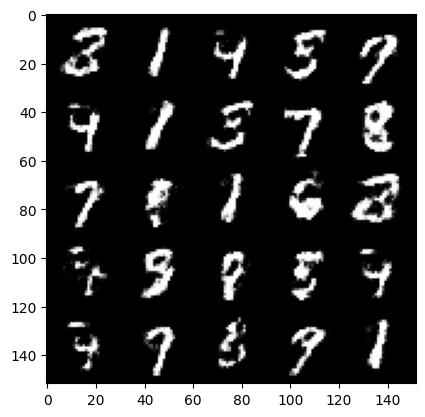

In [ ]:
from torchvision.utils import make_grid
fake_noise = torch.rand(128,z_dim,device=device)
fake = gen(fake_noise)
unflattened_image = fake.detach().cpu().view(-1, *(1, 28, 28))
loss = get_gen_loss(gen, disc, criterion, 128, z_dim, device)
image_grid = make_grid(unflattened_image[:25], nrow=5)
plt.imshow(image_grid.permute(1, 2, 0).squeeze())
plt.show()

In [ ]:
from torchvision.utils import save_image
save_image(image_grid,"fig.png")

References :
* Goodfellow et al, Generative Adversarial Nets, NeurIPS 2014
* Play with Generative Adversarial Networks (GANs) in your browser
https://poloclub.github.io/ganlab/

* Dive into Deep Learning, Chapter 17
https://d2l.ai/chapter_generative-adversarial-networks/gan.html

* Radford et al, Unsupervised Representation Learning with Deep Convolutional GANs, NeurIPS 2016